In [57]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import ToTensor

from torchinfo import summary
from sklearn.model_selection import train_test_split

from einops import rearrange
from einops.layers.torch import Rearrange
from tqdm import tqdm

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [58]:
# Setup training data
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Setup test data
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32]) 6


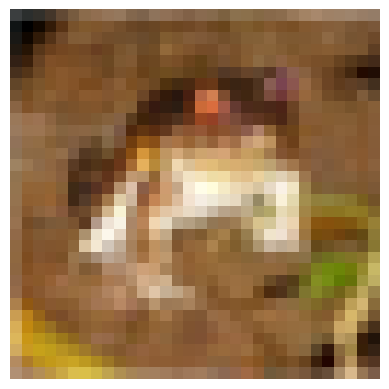

In [59]:
image, label = train_data[0]
print(image.shape, label)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.axis('off')
plt.show()

Shape is: torch.Size([64, 4, 4, 3])


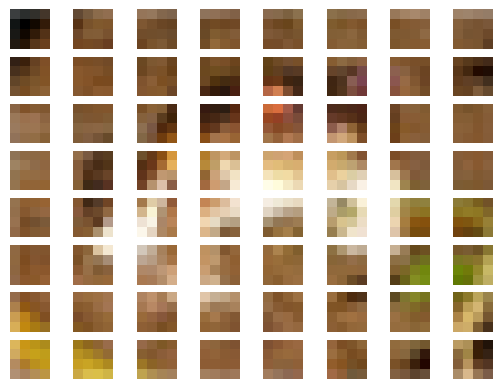

In [60]:
patch_size = 4
image_patchify = rearrange(image, 'c (h p1) (w p2) -> (h w) p1 p2 c', p1=patch_size, p2=patch_size)
print(f'Shape is: {image_patchify.shape}')

h, w = int(image_patchify.shape[0]**0.5), int(image_patchify.shape[0]**0.5)
fig, ax = plt.subplots(h, w)
for i in range(h):
    for j in range(w):
        ax[i, j].imshow(image_patchify[i*h + j])
        ax[i, j].axis('off')
plt.show()

In [61]:
# Networks

class Embeddor(nn.Module):
    """Takes a batch (B, H, W, C) and returns a batch of flattened patches (B, N+1, D)
    where N = (H // patch_size) * (W // patch_size) (+1 for the CLS token)
    and D is the embedding dimension
    A learnable positional embedding is added to each patch
    """

    def __init__(
        self,
        height,
        width,
        patch_size,
        dim,
    ):

        assert height % patch_size == 0, 'Height must be divisible by patch size'
        assert width % patch_size == 0, 'Width must be divisible by patch size'

        super().__init__()

        self.height = height
        self.width = width
        self.patch_size = patch_size
        self.num_patches = (height // patch_size) * (width // patch_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.position_embedding_table = nn.Embedding(self.num_patches + 1, dim)

        self.patch_embedding = nn.Sequential(
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * 3, dim),
        )

    def forward(self, x):
        batch_size = x.shape[0]

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (B, 1, D)
        position_embeddings = self.position_embedding_table(
            torch.arange(self.num_patches + 1, device=x.device)
        )  # (N+1, D)
        x = self.patch_embedding(x)  # (B, H, W, C) -> (B, N, P^2*C) -> (B, N, D)
        x = torch.concat([cls_tokens, x], dim=1)  # (B, N+1, D)
        x += position_embeddings  # (B, N+1, D)

        return x


class Attention(nn.Module):
    """Attention module for a single layer of the ViT, with a skip connection
    """

    def __init__(
        self,
        dim,
        n_heads,
    ):

        super().__init__()
        self.dim = dim
        self.n_heads = n_heads

        self.attention = nn.MultiheadAttention(dim, n_heads, batch_first=True)
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        """ x is a batch of patches (B, N+1, D) 
        """
        x_init = x
        x = self.ln(x)
        x, _ = self.attention(x, x, x, need_weights=False)  # (B, N+1, D)
        x = x_init + x  # (B, N+1, D)
        return x


class FeedForward(nn.Module):
    """Feed forward module for a single layer of the ViT, with a skip connection
    """

    def __init__(
        self,
        dim,
        hidden_dim,
        dropout=0.1,
    ):

        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout

        self.ff1 = nn.Linear(dim, hidden_dim)
        self.ff2 = nn.Linear(hidden_dim, dim)
        self.ln = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        """ x is a batch of patches (B, N+1, D) 
        """

        x_init = x
        x = self.ln(x)
        x = self.activation(self.ff1(x))  # (B, N+1, D)
        x = self.dropout(x)
        x = self.ff2(x)  # (B, N+1, D)
        x = self.dropout(x)
        x = x_init + x  # (B, N+1, D)

        return x

class ViT(nn.Module):

    def __init__(
        self,
        height,
        width,
        patch_size,
        dim,
        n_heads,    
        n_layers,
        hidden_dim,
        n_classes,
        dropout=0.1,
    ):

        super().__init__()

        self.height = height
        self.width = width
        self.patch_size = patch_size
        self.dim = dim
        self.n_heads = n_heads
        self.n_layers = n_layers
    
        self.embeddor = Embeddor(height, width, patch_size, dim)
        self.encoder = nn.ModuleList([
            nn.Sequential(
                Attention(dim, n_heads),
                FeedForward(dim, hidden_dim, dropout),
            ) for _ in range(n_layers)
        ])
        self.classifier_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_classes)
        )

    def forward(self, x):
        """ x is a tensor of dim (B, H, W, C)
        """
        x = self.embeddor(x)  # (B, N+1, D)
        for layer in self.encoder:
            x = layer(x) # (B, N+1, D)
        
        return self.classifier_head(x[:, 0])

In [62]:
@torch.inference_mode()
def estimate_loss(model, data_loader, device):
    """Estimates the loss and accuracy of a model on a given dataset
    """
    model.eval()
    total_loss, accuracy = 0, 0
    criterion = nn.CrossEntropyLoss()
    for batch in tqdm(data_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        # ensure x is of shape (B, H, W, C)
        x = rearrange(x, 'b c h w -> b h w c')
        y_hat = model(x)
        total_loss += criterion(y_hat, y).item()
        accuracy += (y_hat.argmax(1) == y).sum().item()
    model.train()
    return total_loss / len(data_loader), accuracy / len(data_loader.dataset)

In [63]:
# Hyperparameters
batch_size = 32
patch_size = 4
dim = 512
n_heads = 8
n_layers = 6
hidden_dim = 512
n_classes = 10
dropout = 0.1
lr = 1e-4
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Split training data into training and validation sets
train_data_, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data.targets)


# Setup data loaders
train_dataloader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Setup model
model = ViT(
    height=32,
    width=32,
    patch_size=patch_size,
    dim=dim,
    n_heads=n_heads,
    n_layers=n_layers,
    hidden_dim=hidden_dim,
    n_classes=n_classes,
    dropout=dropout,
).to(device)
print(summary(model=model, input_size=(batch_size, 32, 32, 3)))

# Setup optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Setup loss function
criterion = nn.CrossEntropyLoss()

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [32, 10]                  --
├─Embeddor: 1-1                               [32, 65, 512]             512
│    └─Embedding: 2-1                         [65, 512]                 33,280
│    └─Sequential: 2-2                        [32, 64, 512]             --
│    │    └─Rearrange: 3-1                    [32, 64, 48]              --
│    │    └─Linear: 3-2                       [32, 64, 512]             25,088
├─ModuleList: 1-2                             --                        --
│    └─Sequential: 2-3                        [32, 65, 512]             --
│    │    └─Attention: 3-3                    [32, 65, 512]             1,051,648
│    │    └─FeedForward: 3-4                  [32, 65, 512]             526,336
│    └─Sequential: 2-4                        [32, 65, 512]             --
│    │    └─Attention: 3-5                    [32, 65, 512]             1,

In [64]:
training_losses, validation_losses, validation_accuracies = [], [], []

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(pbar := tqdm(train_dataloader)):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        # ensure x is of shape (B, H, W, C)
        x = rearrange(x, 'b c h w -> b h w c')
        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Epoch {epoch+1}/{epochs}')
        
    print(f'Epoch {epoch+1} training loss: {total_loss / len(train_dataloader)}')
    training_losses.append(total_loss / len(train_dataloader))

    # Find validation loss and accuracy
    val_loss, val_acc = estimate_loss(model, val_dataloader, device)
    print(f'Validation loss: {val_loss}, validation accuracy: {val_acc}')
    validation_losses.append(val_loss)
    validation_accuracies.append(val_acc)
    

Epoch 1/10: 100%|██████████| 1250/1250 [11:21<00:00,  1.83it/s]


Epoch 1 training loss: 1.8299622512817382


100%|██████████| 313/313 [00:39<00:00,  7.85it/s]


Validation loss: 1.6465221464443511, validation accuracy: 0.4162


Epoch 2/10: 100%|██████████| 1250/1250 [11:27<00:00,  1.82it/s]


Epoch 2 training loss: 1.5459349901199342


100%|██████████| 313/313 [00:42<00:00,  7.43it/s]


Validation loss: 1.4626414932001133, validation accuracy: 0.4795


Epoch 3/10: 100%|██████████| 1250/1250 [12:53<00:00,  1.62it/s]


Epoch 3 training loss: 1.3925910274982451


100%|██████████| 313/313 [00:46<00:00,  6.73it/s]


Validation loss: 1.402304248307079, validation accuracy: 0.4966


Epoch 4/10: 100%|██████████| 1250/1250 [12:46<00:00,  1.63it/s]


Epoch 4 training loss: 1.2822420883178711


100%|██████████| 313/313 [00:42<00:00,  7.45it/s]


Validation loss: 1.301111220932616, validation accuracy: 0.5325


Epoch 5/10: 100%|██████████| 1250/1250 [11:54<00:00,  1.75it/s]


Epoch 5 training loss: 1.1992360026359559


100%|██████████| 313/313 [00:43<00:00,  7.13it/s]


Validation loss: 1.286618078478609, validation accuracy: 0.5441


Epoch 6/10: 100%|██████████| 1250/1250 [12:32<00:00,  1.66it/s]


Epoch 6 training loss: 1.1191782612800598


100%|██████████| 313/313 [00:46<00:00,  6.79it/s]


Validation loss: 1.2443532216282318, validation accuracy: 0.5553


Epoch 7/10: 100%|██████████| 1250/1250 [20:44<00:00,  1.00it/s]


Epoch 7 training loss: 1.0439087262630462


100%|██████████| 313/313 [00:55<00:00,  5.61it/s]


Validation loss: 1.241986617303123, validation accuracy: 0.5623


Epoch 8/10: 100%|██████████| 1250/1250 [21:42<00:00,  1.04s/it] 


Epoch 8 training loss: 0.9606047746896744


100%|██████████| 313/313 [01:07<00:00,  4.63it/s]


Validation loss: 1.217855708096355, validation accuracy: 0.5721


Epoch 9/10: 100%|██████████| 1250/1250 [13:18<00:00,  1.56it/s]


Epoch 9 training loss: 0.8712215067863465


100%|██████████| 313/313 [00:40<00:00,  7.67it/s]


Validation loss: 1.2609461039399947, validation accuracy: 0.5747


Epoch 10/10: 100%|██████████| 1250/1250 [09:56<00:00,  2.10it/s]


Epoch 10 training loss: 0.7844659359693528


100%|██████████| 313/313 [00:42<00:00,  7.30it/s]

Validation loss: 1.3268696446769155, validation accuracy: 0.5616


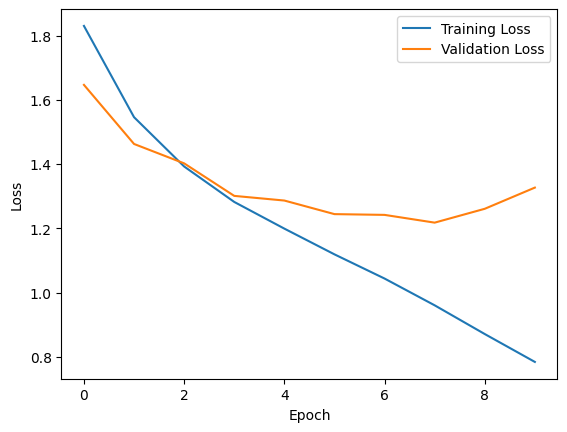

In [67]:
# prompt: Plot loss curves

plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [66]:
# prompt: Find accuracy on test_set

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_dataloader):
        images = images.to(device)
        images = rearrange(images, 'b c h w -> b h w c')
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


100%|██████████| 313/313 [00:41<00:00,  7.62it/s]

Accuracy of the model on the test images: 57.17 %
